In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import scipy.stats as stats
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
from pandas.tseries.offsets import MonthBegin

In [2]:
df_raw=pd.read_csv('2017_10_csv.csv')

In [3]:
idfeat = pd.read_csv('ID_feature_csv.csv')
idfeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
ID                   30000 non-null object
Contractual_power    30000 non-null float64
Phases               30000 non-null object
Macrocluster         30000 non-null object
PV_generation        30000 non-null object
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [4]:
# Let's create a sample to work with efficiently.

df = df_raw.sample(frac=0.05, replace=False, random_state=42)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579381 entries, 7814657 to 8871159
Data columns (total 4 columns):
id          579381 non-null object
yyyymmdd    579381 non-null object
hh          579381 non-null int64
consumo     579381 non-null int64
dtypes: int64(2), object(2)
memory usage: 22.1+ MB


In [6]:
#Let's create a timestamp to identify duplicate values

#df.drop(columns='hora',inplace=True)
df.hora=df.hh.astype(str)
df['DateTime'] = pd.to_datetime(df['yyyymmdd'] + ' ' + df.hora + ':00:00')

df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


,id,yyyymmdd,hh,consumo,DateTime
7814657,ID02196,2017-10-24,16,289,2017-10-24 16:00:00
1687468,ID15274,2017-10-26,4,434,2017-10-26 04:00:00
431115,ID07681,2017-10-08,10,0,2017-10-08 10:00:00
7469643,ID11134,2017-10-08,11,124,2017-10-08 11:00:00
2011870,ID21961,2017-10-18,20,369,2017-10-18 20:00:00


In [7]:
# Let's drop duplicate values.

dupli=df[df[['id','DateTime']].duplicated()]
print(dupli.shape)
print(dupli.head(20))

(11, 5)
               id    yyyymmdd  hh  consumo            DateTime
7849554   ID03477  2017-10-17   8      317 2017-10-17 08:00:00
317478    ID00304  2017-10-02   5      993 2017-10-02 05:00:00
1200284   ID00075  2017-10-18  14       85 2017-10-18 14:00:00
10734907  ID00101  2017-10-24  23      129 2017-10-24 23:00:00
10240275  ID00862  2017-10-06  22       83 2017-10-06 22:00:00
1201105   ID00075  2017-10-12   2      348 2017-10-12 02:00:00
1200249   ID00075  2017-10-02  13      862 2017-10-02 13:00:00
10239607  ID00862  2017-10-01  12      137 2017-10-01 12:00:00
7849241   ID03477  2017-10-02   8      100 2017-10-02 08:00:00
4383317   ID22623  2017-10-05   6      100 2017-10-05 06:00:00
4382751   ID22623  2017-10-06  15      147 2017-10-06 15:00:00


In [8]:
# Let's make sure what we identified is a duplicate value.

print(df[(df.id=='ID00304')&(df.DateTime=='2017-10-02 05:00:00')])

             id    yyyymmdd  hh  consumo            DateTime
292605  ID00304  2017-10-02   5     1374 2017-10-02 05:00:00
317478  ID00304  2017-10-02   5      993 2017-10-02 05:00:00


In [9]:
# Removing duplicate values and comparing.

df_wod=df[~df[['id','DateTime']].duplicated()]
print(df.shape,df_wod.shape)

(579381, 5) (579370, 5)


In [10]:
# Let's join the internal features now with the our consumption dataset

df_m=df_wod.set_index('id').join(idfeat.set_index('ID'), how='left')

In [11]:
df_m.head()

,yyyymmdd,hh,consumo,DateTime,Contractual_power,Phases,Macrocluster,PV_generation
ID00009,2017-10-05,23,1833,2017-10-05 23:00:00,2.5,M,Small Enterprise - Other,NO
ID00009,2017-10-12,14,688,2017-10-12 14:00:00,2.5,M,Small Enterprise - Other,NO
ID00009,2017-10-02,9,78,2017-10-02 09:00:00,2.5,M,Small Enterprise - Other,NO
ID00009,2017-10-24,11,81,2017-10-24 11:00:00,2.5,M,Small Enterprise - Other,NO
ID00009,2017-10-08,7,78,2017-10-08 07:00:00,2.5,M,Small Enterprise - Other,NO


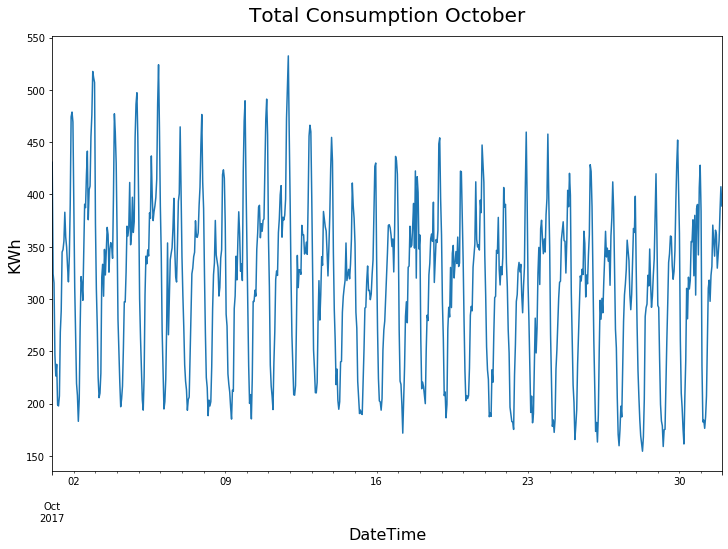

In [13]:
# Some EDA

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Total Consumption October", fontsize=20, y=1.02)
ax.set_ylabel("KWh", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)

df.groupby('DateTime').consumo.mean().plot(kind='line')

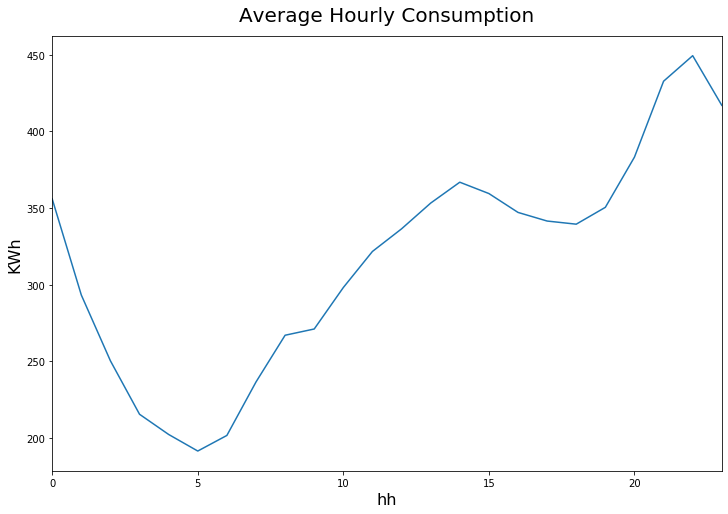

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Average Hourly Consumption", fontsize=20, y=1.02)
ax.set_ylabel("KWh", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)

df.groupby('hh').consumo.mean().plot(kind='line')

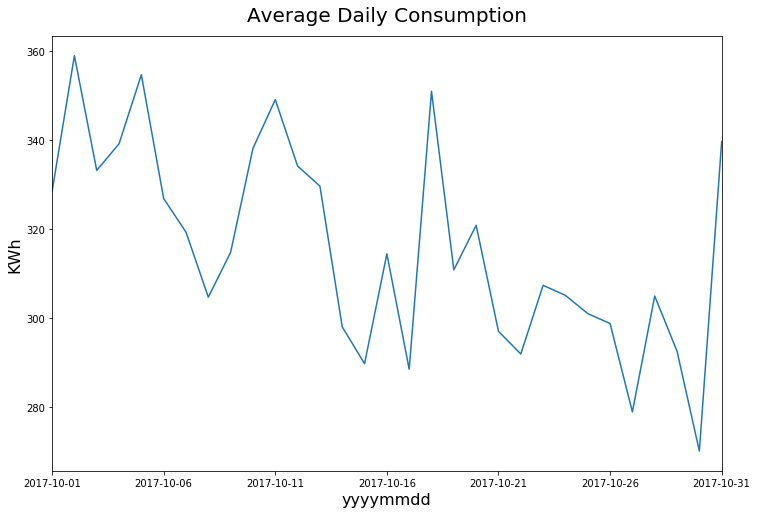

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Average Daily Consumption", fontsize=20, y=1.02)
ax.set_ylabel("KWh", fontsize=16)
ax.set_xlabel("Hour", fontsize=16)

df.groupby('yyyymmdd').consumo.mean().plot(kind='line')

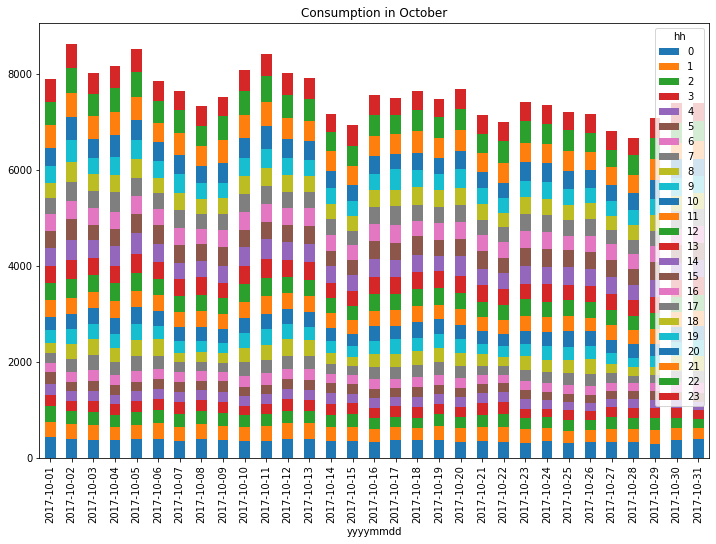

In [42]:
stacked_hourly = df.groupby(['yyyymmdd','hh']).consumo.mean().unstack()
stacked_hourly.plot(kind='bar', stacked=True,figsize=(12,8), title="Consumption in October")

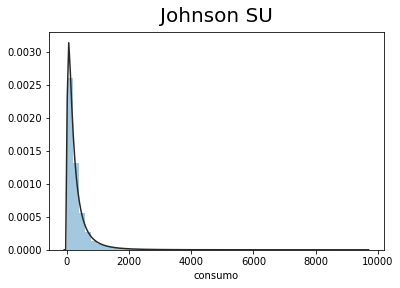

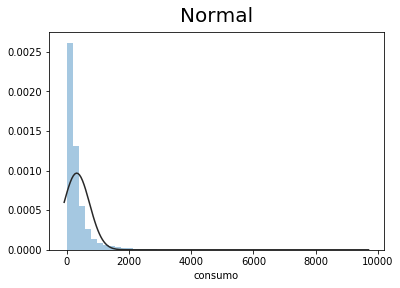

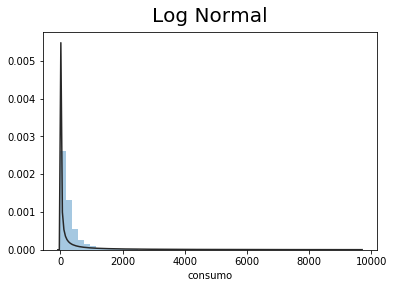

In [43]:
y = df['consumo']
plt.figure(1) 
plt.title('Johnson SU', size=20, y=1.02)
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.show()
#plt.savefig('images/04a-precio-johnson.png')

plt.figure(2)
plt.title('Normal', size=20, y=1.02)
sns.distplot(y, kde=False, fit=stats.norm)
plt.show()
#plt.savefig('images/04b-precio-normal.png')

plt.figure(3)
plt.title('Log Normal', size=20, y=1.02)
sns.distplot(y, kde=False, fit=stats.lognorm)
plt.show()
#plt.savefig('images/04c-precio-log-normal, y=1.02.png')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Density')

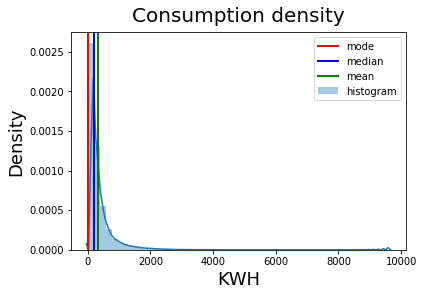

In [44]:
# Let's understand the consumption density rate.
mean=df['consumo'].mean()
median=df['consumo'].median()
mode=df['consumo'].mode().get_values()[0]
asimetria_Pearson = ((mean-mode)/df['consumo'].std()).round(2)

ax_hist = sns.distplot(df['consumo'],)
ax_hist.axvline(mode, color='r', linestyle='-',lw=2)
ax_hist.axvline(median, color='b', linestyle='-',lw=2)
ax_hist.axvline(mean, color='g', linestyle='-',lw=2)
ax_hist.legend(['mode','median','mean','histogram'],)
ax_hist.set_title("Consumption density",fontsize=20, y=1.02)
ax_hist.set_xlabel("KWH",fontsize=18)
ax_hist.set_ylabel("Density", fontsize=18)

In [118]:
# Now, in order to measure correlation between all variables, 
# we have to convert our categorical variables into an encoded variable.

cat_features=['Phases','Macrocluster','PV_generation']
ohe = OneHotEncoder()
ohe.fit_transform(df_m[cat_features])
categories = ohe.categories_

#one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(df_m[cat_features])
df_ohe = df_m.join(one_hot_encoded.add_suffix("_oh"))

print(categories, df_ohe.columns)

[array(['M', 'T'], dtype=object), array(['HOUSEHOLD', 'Public offices', 'Small Enterprise - Other',
       'Small Enterprise - Retail', 'Small Enterprise - other',
       'Small Enterprise - retail',
       'Uncertain Household or Small Enterprise'], dtype=object), array(['NO', 'Yes installed in 2016', 'Yes installed in 2017',
       'Yes installed in 2018', 'Yes installed in 2019',
       'Yes installed in 2020'], dtype=object)] Index(['yyyymmdd', 'hh', 'consumo', 'DateTime', 'Contractual_power', 'Phases',
       'Macrocluster', 'PV_generation', 'Phases_1_oh', 'Phases_2_oh',
       'Macrocluster_1_oh', 'Macrocluster_2_oh', 'Macrocluster_3_oh',
       'Macrocluster_4_oh', 'Macrocluster_5_oh', 'Macrocluster_6_oh',
       'Macrocluster_7_oh', 'PV_generation_1_oh', 'PV_generation_2_oh',
       'PV_generation_3_oh', 'PV_generation_4_oh', 'PV_generation_5_oh',
       'PV_generation_6_oh'],
      dtype='object')


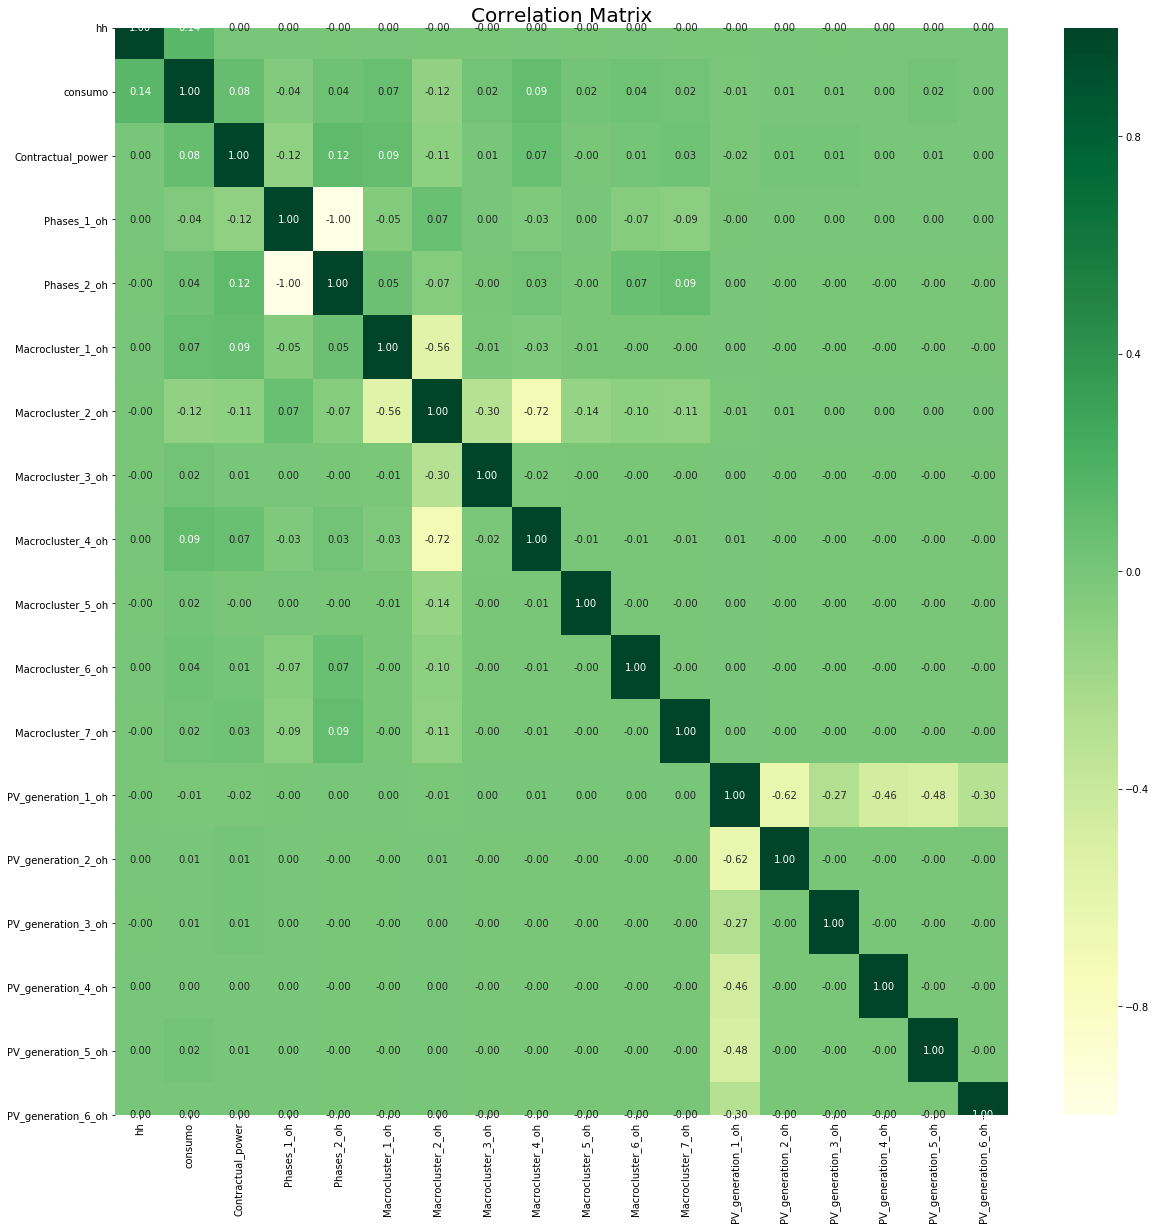

In [130]:
# Now we can check the correlation of Internal Features

plt.figure(figsize=(20,20))
cm= df_ohe.corr()
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("client_feat_corr.png")

plt.show()

In [131]:
cm['consumo'].sort_values(ascending=False)

consumo               1.000000
hh                    0.139182
Macrocluster_4_oh     0.086992
Contractual_power     0.082755
Macrocluster_1_oh     0.072078
Phases_2_oh           0.042749
Macrocluster_6_oh     0.035149
Macrocluster_7_oh     0.024689
Macrocluster_3_oh     0.023440
PV_generation_5_oh    0.016507
Macrocluster_5_oh     0.016011
PV_generation_2_oh    0.006235
PV_generation_3_oh    0.006118
PV_generation_6_oh    0.004455
PV_generation_4_oh    0.000173
PV_generation_1_oh   -0.014930
Phases_1_oh          -0.042749
Macrocluster_2_oh    -0.123366
Name: consumo, dtype: float64

In [45]:
# Let's bring in the external features

extF = pd.read_excel('TempSantigo.xlsx')
extF.head()

,date,hour,cobmox(combination of date and hour),temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h,clouds_all,weather_description
0,2017-10-01,1900-01-06 00:00:00,2017-10-01 00:00:00,10.14,9.63,9.60,11.0,1018,94,0.5,160,NaN,NaN,43,scattered clouds
1,2017-10-01,1900-01-06 01:00:00,2017-10-01 01:00:00,9.80,9.20,9.39,10.0,1018,94,0.5,160,NaN,NaN,32,scattered clouds
2,2017-10-01,1900-01-06 02:00:00,2017-10-01 02:00:00,8.79,5.74,-0.15,10.0,1019,93,3.6,170,NaN,NaN,40,scattered clouds
3,2017-10-01,1900-01-06 03:00:00,2017-10-01 03:00:00,7.93,5.73,-0.52,9.0,1019,93,2.1,170,NaN,NaN,40,scattered clouds
4,2017-10-01,1900-01-06 04:00:00,2017-10-01 04:00:00,7.67,5.83,-1.43,9.0,1019,93,1.5,180,NaN,NaN,1,fog


In [105]:
# And cross reference them to our energy consuption by timestamp

cons = df.groupby(['DateTime']).consumo.mean().to_frame()
cons = cons.reset_index()
cons.head()
#extF.rename(columns={"cobmox(combination of date and hour)":"DateTime"},inplace=True)
cons.DateTime = pd.to_datetime(cons.DateTime)
df_mext = cons.join(extF, how='left', rsuffix='_extF')
df_mext.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 17 columns):
DateTime               744 non-null datetime64[ns]
consumo                744 non-null float64
date                   744 non-null datetime64[ns]
hour                   744 non-null datetime64[ns]
DateTime_extF          744 non-null datetime64[ns]
temp                   744 non-null float64
feels_like             744 non-null float64
temp_min               744 non-null float64
temp_max               744 non-null float64
pressure               744 non-null int64
humidity               744 non-null int64
wind_speed             744 non-null float64
wind_deg               744 non-null int64
rain_1h                8 non-null float64
snow_1h                0 non-null float64
clouds_all             744 non-null int64
weather_description    744 non-null object
dtypes: datetime64[ns](4), float64(8), int64(4), object(1)
memory usage: 98.9+ KB


In [117]:
# Let's encode the categorical values in our external factors now

qual = ['weather_description']
ohe_e = OneHotEncoder()
ohe_e.fit_transform(df_mext[qual])
categories_e = ohe_e.categories_

one_hot_enc_e = ce.OneHotEncoder()
one_hot_encoded_e = one_hot_enc_e.fit_transform(df_mext['weather_description'])
df_ohe_e = df_mext.join(one_hot_encoded_e.add_suffix("_oh"))

print(categories, df_ohe_e.columns)

[array(['M', 'T'], dtype=object), array(['HOUSEHOLD', 'Public offices', 'Small Enterprise - Other',
       'Small Enterprise - Retail', 'Small Enterprise - other',
       'Small Enterprise - retail',
       'Uncertain Household or Small Enterprise'], dtype=object), array(['NO', 'Yes installed in 2016', 'Yes installed in 2017',
       'Yes installed in 2018', 'Yes installed in 2019',
       'Yes installed in 2020'], dtype=object)] Index(['DateTime', 'consumo', 'date', 'hour', 'DateTime_extF', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_description', 'weather_description_1_oh',
       'weather_description_2_oh', 'weather_description_3_oh',
       'weather_description_4_oh', 'weather_description_5_oh',
       'weather_description_6_oh', 'weather_description_7_oh',
       'weather_description_8_oh', 'weather_description_9_oh',
       'weather_description_10_oh', 'weather_de

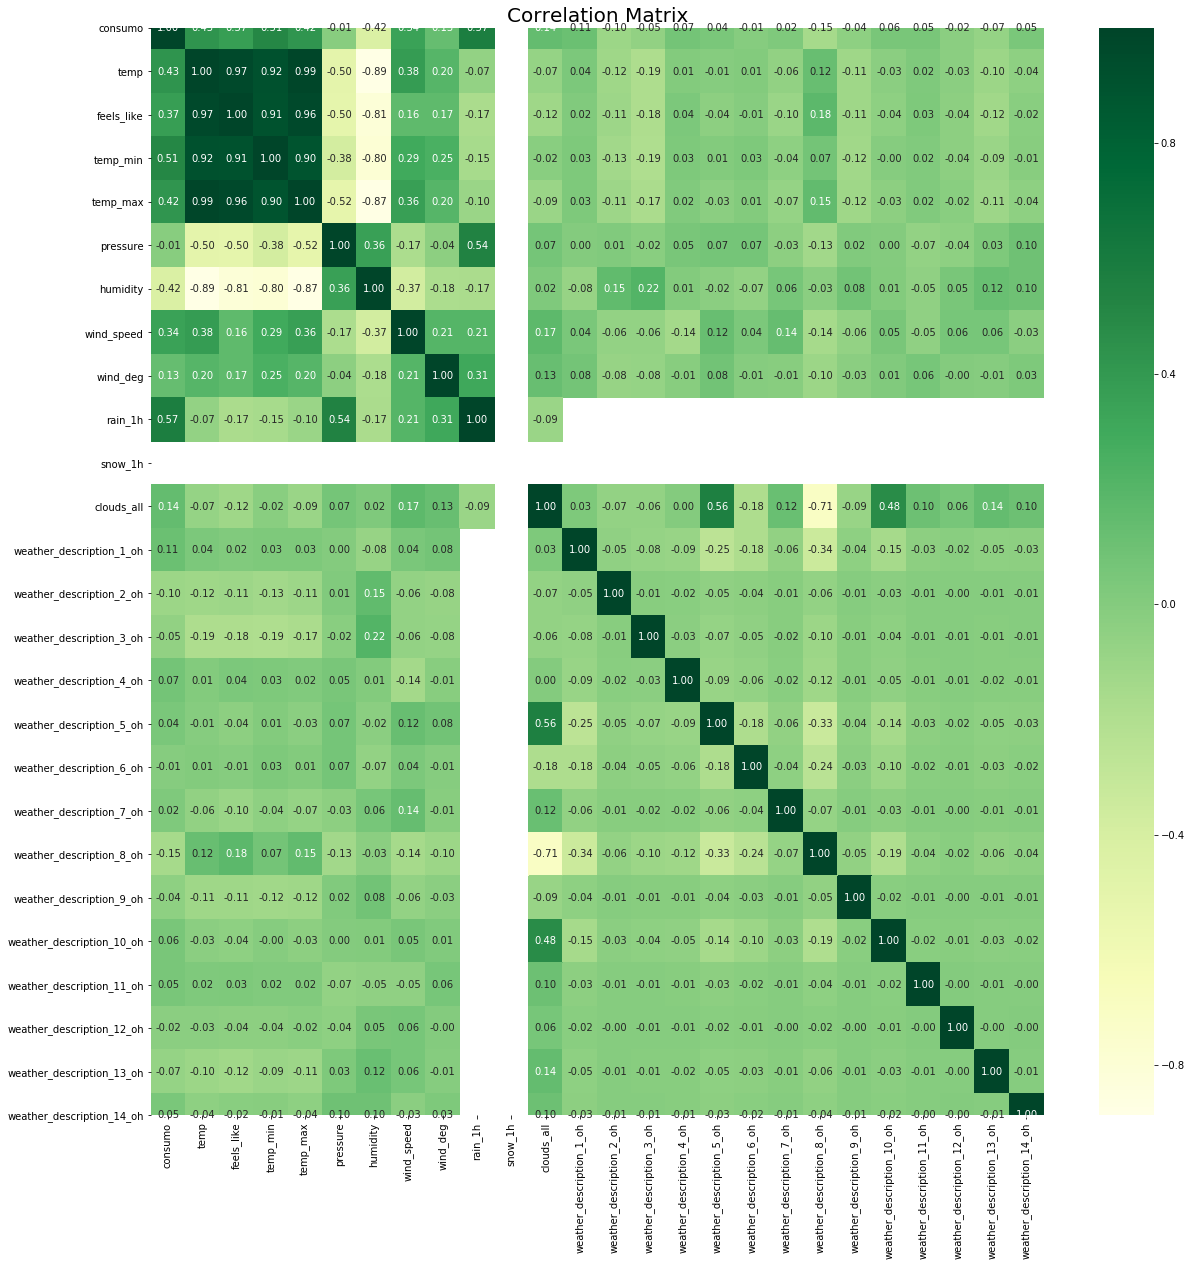

In [128]:
# Correlation External Features

plt.figure(figsize=(20,20))
cm_e= df_ohe_e.corr()
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn")
hm.set_title('Correlation Matrix', fontsize=20, y=1.02)

#plt.savefig("external_feat_corr.png")

plt.show()

In [129]:
cm['consumo'].sort_values(ascending=False)

consumo                      1.000000
rain_1h                      0.572752
temp_min                     0.508438
temp                         0.429858
temp_max                     0.423368
feels_like                   0.371513
wind_speed                   0.344865
clouds_all                   0.143419
wind_deg                     0.134959
weather_description_1_oh     0.111169
weather_description_4_oh     0.074994
weather_description_10_oh    0.056244
weather_description_11_oh    0.051413
weather_description_14_oh    0.047415
weather_description_5_oh     0.043687
weather_description_7_oh     0.021019
weather_description_6_oh    -0.009087
pressure                    -0.011222
weather_description_12_oh   -0.024544
weather_description_9_oh    -0.043642
weather_description_3_oh    -0.054067
weather_description_13_oh   -0.074553
weather_description_2_oh    -0.099874
weather_description_8_oh    -0.145977
humidity                    -0.421561
snow_1h                           NaN
Name: consum

In [ ]:
# Let's measure Feature Importance and create a predictive model to correct nulls in the dataset
# train_set, test_set = train_test_split(df_raw, test_size = 0.2, random_state = 42)